In [1]:
%cd /qbio/junsoopablo/2022_bioinfo/project/binfo1-datapack1

/qbio/junsoopablo/2022_bioinfo/project/binfo1-datapack1


In [2]:
import numpy as np
import pickle
from sklearn import decomposition
from scipy.stats import spearmanr
from functools import reduce
import matplotlib.ticker as ticker
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO
import matplotlib.colors as mcolors
import pylab as pl
from collections import Counter
from matplotlib import colors as colors

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
sns.set_style("whitegrid")

# fig.patch.set_facecolor('white')
%matplotlib inline

In [3]:
trgenename = pd.read_csv('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/references/Mouse-SCV2.transcript-genenames.txt', sep='\t', names=['transcript_id', 'gene_name'], index_col=0)
codinglengths = pd.read_csv('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/references/transcript-coding-lengths.txt', sep='\t',
                            names='transcript_id gene_id utr5 cds utr3 noncoding'.split())

repisoform = pickle.load(open('/qbio/junsoopablo//02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/representative-isoforms.pickle','rb'))


codinglengths['genesize'] = codinglengths['utr5'] + codinglengths['cds'] + codinglengths['utr3']
codinglengths_gene = pd.merge(codinglengths, trgenename, how='inner', left_on='transcript_id', right_index=True)
codinglengths_gene = codinglengths_gene.loc[codinglengths_gene['transcript_id'].isin(repisoform['transcript_id'])]

cdslen_dic = codinglengths_gene.set_index('transcript_id')['cds'].to_dict()
utr3len_dic = codinglengths_gene.set_index('transcript_id')['utr3'].to_dict()
gene_dic = codinglengths_gene.copy(deep=True)
gene_dic['gene_id'] = gene_dic['gene_id'].str.split('.',expand=True)[0]
gene_dic = gene_dic.set_index('transcript_id')['gene_id'].to_dict()

genelen_dic = codinglengths_gene.set_index('transcript_id')['genesize'].to_dict()
genesym_dic = codinglengths_gene[['gene_id', 'gene_name']]
genesym_dic['gene_id'] = genesym_dic['gene_id'].str.split('.',expand=True)[0]
genesym_dic = genesym_dic.set_index('gene_id')['gene_name'].to_dict()


codinglengths_gene.head()

/tmp/ipykernel_1845642/1395101429.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genesym_dic['gene_id'] = genesym_dic['gene_id'].str.split('.',expand=True)[0]


,transcript_id,gene_id,utr5,cds,utr3,noncoding,genesize,gene_name
0,ENSMUST00000000001.5,ENSMUSG00000000001.5,141,1065,2056,0,3262,Gnai3
1,ENSMUST00000000003.14,ENSMUSG00000000003.16,140,525,237,0,902,Pbsn
2,ENSMUST00000000010.9,ENSMUSG00000020875.10,85,753,1736,0,2574,Hoxb9
3,ENSMUST00000000028.14,ENSMUSG00000000028.16,313,1701,129,0,2143,Cdc45
5,ENSMUST00000000049.6,ENSMUSG00000000049.12,51,1038,101,0,1190,Apoh


In [4]:
codinglengths_gene.loc[codinglengths_gene['gene_name']=='Rpl26']

,transcript_id,gene_id,utr5,cds,utr3,noncoding,genesize,gene_name
75713,ENSMUST00000167436.3,ENSMUSG00000060938.15,128,438,40,0,606,Rpl26


# Convert genome bam to transcript bam

In [5]:
# ! java -jar /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/contrib/ubu.jar \
#     sam-xlate --bed /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/Mouse-SCV2.bed12 \
#         --in filtered-RPF-siLuc.bam --out filtered-RPF-siLuc_transcriptome_tmp.bam --single --reverse
# ! samtools view -h filtered-RPF-siLuc_transcriptome_tmp.bam | \
#         awk -vOFS='\t' '/^@/ { print $0; } \
#         /^[^@]/ { $2 = xor($2, 8); print }' | \
#     samtools sort -@ 10 --write-index -o filtered-RPF-siLuc_transcriptome.bam -

In [6]:
# ! java -jar /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/contrib/ubu.jar \
#     sam-xlate --bed /qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/references/Mouse-SCV2.bed12 \
#         --in filtered-RPF-siLin28a.bam --out filtered-RPF-siLin28a_transcriptome_tmp.bam --single --reverse
# ! samtools view -h filtered-RPF-siLin28a_transcriptome_tmp.bam | \
#         awk -vOFS='\t' '/^@/ { print $0; } \
#         /^[^@]/ { $2 = xor($2, 8); print }' | \
#     samtools sort -@ 10 --write-index -o filtered-RPF-siLin28a_transcriptome.bam -

# convert bam to rpf counts

In [ ]:
# !bedtools genomecov -ibam filtered-RPF-siLuc_transcriptome.bam -bg -5 > siLuc_transcriptome.bed
# !head siLuc_transcriptome.bed

ENSMUST00000018875.13	199	200	1
ENSMUST00000018875.13	201	202	1
ENSMUST00000018875.13	224	225	1
ENSMUST00000018875.13	233	234	16
ENSMUST00000018875.13	234	235	5
ENSMUST00000018875.13	236	238	2
ENSMUST00000018875.13	238	239	1
ENSMUST00000018875.13	240	241	1
ENSMUST00000018875.13	247	248	1
ENSMUST00000018875.13	249	250	3


In [ ]:
# !bedtools genomecov -ibam filtered-RPF-siLin28a_transcriptome.bam -bg -5 > siLin28a_transcriptome.bed
# !head siLin28a_transcriptome.bed

ENSMUST00000018875.13	202	203	1
ENSMUST00000018875.13	220	221	1
ENSMUST00000018875.13	223	224	2
ENSMUST00000018875.13	226	227	1
ENSMUST00000018875.13	233	235	2
ENSMUST00000018875.13	247	248	1
ENSMUST00000018875.13	255	256	1
ENSMUST00000018875.13	256	257	2
ENSMUST00000018875.13	258	261	1
ENSMUST00000018875.13	273	274	1


# Identify transmembrane segments

In [5]:
protstbl = pickle.load(open('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/analysis/rpf-function/uniprot-localization-tags.pickle', 'rb'))
uniprot_ensgene_map = pickle.load(open('/qbio/junsoopablo/02_Projects/01_SCV2-Ribo/07_Chang/scv2-riboseq/ribojun/analysis/rpf-function/uniprot-ensembl-mapping.pickle', 'rb'))
protstbl = pd.merge(protstbl,uniprot_ensgene_map, left_on='ID', right_on='uniprot_id')
protstbl

,ID,topology,length,annotags,subcellular location,tissue specificity,tail-anchored,Apical cell membrane,Basolateral cell membrane,Cell junction,...,have-nterm-signal,have-signal,have-subcellular-location,nterm-cytoplasmic,nterm-extracellular,nterm-lumenal,nterm-mitochondrial intermembrane,nterm-mitochondrial matrix,uniprot_id,ensembl_gene_id
0,A0A075B5J2_MOUSE,"{'SIGNAL': [(0, 15, {'evidence': 'ECO:0000256|...",110,"{have-signal, have-nterm-signal}",NaN,NaN,False,False,False,False,...,True,True,False,False,False,False,False,False,A0A075B5J2_MOUSE,ENSMUSG00000076481
1,A0A0A6YYE5_MOUSE,"{'SIGNAL': [(0, 22, {'evidence': 'ECO:0000256|...",119,"{have-signal, have-nterm-signal}",NaN,NaN,False,False,False,False,...,True,True,False,False,False,False,False,False,A0A0A6YYE5_MOUSE,ENSMUSG00000094315
2,A0A1B0GT27_MOUSE,NaN,204,{},NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,A0A1B0GT27_MOUSE,ENSMUSG00000108348
3,A0A1B0GT39_MOUSE,NaN,78,{},NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,A0A1B0GT39_MOUSE,ENSMUSG00000109833
4,A0A286YDL3_MOUSE,NaN,209,{},NaN,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,A0A286YDL3_MOUSE,ENSMUSG00000099655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31890,TSLP_MOUSE,"{'SIGNAL': [(0, 19, {'evidence': 'ECO:0000255'...",140,"{have-signal, have-subcellular-location, have-...","[(Secreted, [ECO:0000269|PubMed:10974033])]",NaN,False,False,False,False,...,True,True,True,False,False,False,False,False,TSLP_MOUSE,ENSMUSG00000024379
31891,SERC3_MOUSE,"{'TOPO_DOM': [(0, 96, {'note': 'Extracellular'...",472,"{Multi-pass membrane protein, nterm-extracellu...","[(Cell membrane, [ECO:0000269|PubMed:12486168]...",Highly expressed in the neuronal populations s...,False,False,False,False,...,False,False,True,False,True,False,False,False,SERC3_MOUSE,ENSMUSG00000017707
31892,SAE1_MOUSE,NaN,350,"{Nucleus, have-subcellular-location}","[(Nucleus, [ECO:0000250])]","Broadly expressed, with highest levels in test...",False,False,False,False,...,False,False,True,False,False,False,False,False,SAE1_MOUSE,ENSMUSG00000052833
31893,SAE1_MOUSE,NaN,350,"{Nucleus, have-subcellular-location}","[(Nucleus, [ECO:0000250])]","Broadly expressed, with highest levels in test...",False,False,False,False,...,False,False,True,False,False,False,False,False,SAE1_MOUSE,ENSMUSG00000052833


In [6]:
signal_genes = protstbl.loc[protstbl['have-signal']==True]
signal_genes = signal_genes['ensembl_gene_id'].to_list()

tail_genes = protstbl.loc[protstbl['tail-anchored']==True]
tail_genes = tail_genes['ensembl_gene_id'].to_list()

multi_genes = protstbl.loc[protstbl['Multi-pass membrane protein']==True]
single_genes = protstbl.loc[protstbl['Single-pass membrane protein']==True]

multi_genes = multi_genes['ensembl_gene_id'].to_list()
single_genes = single_genes['ensembl_gene_id'].to_list()
transmem_dic = {'multi':multi_genes, 'single':single_genes}
transmem_dic = {k: oldk for oldk, oldv in transmem_dic.items() for k in oldv}


In [7]:
membrane_prot = protstbl.loc[(protstbl['Single-pass membrane protein']==True) | (protstbl['Multi-pass membrane protein']==True)]
#['ensembl_gene_id'].unique()
membrane_prot = membrane_prot[['ensembl_gene_id','topology']]
membrane_prot['transmembrane1'] = membrane_prot['topology'].apply(lambda x: x.get('TRANSMEM') if isinstance(x, dict)==True else '')
membrane_prot['transmembrane'] = membrane_prot['transmembrane1'].apply(lambda x: [(i[0]*3,i[1]*3+3) for i in x] if isinstance(x, list)==True else '')
membrane_prot = membrane_prot.loc[membrane_prot['transmembrane']!='']
membrane_prot

,ensembl_gene_id,topology,transmembrane1,transmembrane
7,ENSMUSG00000078599,"{'SIGNAL': [(0, 25, {'evidence': 'ECO:0000255'...","[(244, 265, {'note': 'Helical', 'evidence': 'E...","[(732, 798), (864, 930), (993, 1059)]"
30,ENSMUSG00000091682,"{'TRANSMEM': [(137, 160, {'note': 'Helical', '...","[(137, 160, {'note': 'Helical', 'evidence': 'E...","[(411, 483)]"
39,ENSMUSG00000063730,"{'TRANSMEM': [(287, 308, {'note': 'Helical', '...","[(287, 308, {'note': 'Helical', 'evidence': 'E...","[(861, 927)]"
40,ENSMUSG00000063730,"{'TRANSMEM': [(287, 308, {'note': 'Helical', '...","[(287, 308, {'note': 'Helical', 'evidence': 'E...","[(861, 927)]"
41,ENSMUSG00000063730,"{'TRANSMEM': [(287, 308, {'note': 'Helical', '...","[(287, 308, {'note': 'Helical', 'evidence': 'E...","[(861, 927)]"
...,...,...,...,...
31869,ENSMUSG00000035559,"{'TRANSMEM': [(23, 40, {'note': 'Helical', 'ev...","[(23, 40, {'note': 'Helical', 'evidence': 'ECO...","[(69, 123), (186, 252), (303, 369)]"
31873,ENSMUSG00000021432,"{'TRANSMEM': [(45, 66, {'note': 'Helical', 'ev...","[(45, 66, {'note': 'Helical', 'evidence': 'ECO...","[(135, 201), (234, 300), (342, 408), (411, 477..."
31874,ENSMUSG00000021432,"{'TRANSMEM': [(45, 66, {'note': 'Helical', 'ev...","[(45, 66, {'note': 'Helical', 'evidence': 'ECO...","[(135, 201), (234, 300), (342, 408), (411, 477..."
31886,ENSMUSG00000064158,"{'SIGNAL': [(0, 21, {'evidence': 'ECO:0000255'...","[(319, 340, {'note': 'Helical', 'evidence': 'E...","[(957, 1023)]"


In [8]:
def select_signal(row):
    if row==None: return None
    if row[0][1]==None: return None
    else:
        return [row[0][0]*3, row[0][1]*3]

In [9]:
def transmem_region(df, genecol):
    return (np.where(df[genecol].isin(tail_genes), 'Tail-anchored',
                    np.where(df[genecol].isin(multi_genes), 'Multi-pass',
                            np.where(df[genecol].isin(signal_genes), 'N-term signal',
                                    np.where(df[genecol].isin(single_genes), 'No N-term signal', 'Non-ER-associated')))))

In [10]:
membrane_prot['signalpeptide1'] = membrane_prot['topology'].apply(lambda x: x.get('SIGNAL') if isinstance(x, dict)==True else '')
membrane_prot['signalpeptide'] = membrane_prot['signalpeptide1'].apply(lambda x: select_signal(x))
membrane_prot = membrane_prot.drop(columns=['transmembrane1','signalpeptide1','topology'])
membrane_prot['transtype'] = transmem_region(membrane_prot, 'ensembl_gene_id')
membrane_prot

,ensembl_gene_id,transmembrane,signalpeptide,transtype
7,ENSMUSG00000078599,"[(732, 798), (864, 930), (993, 1059)]","[0, 75]",Multi-pass
30,ENSMUSG00000091682,"[(411, 483)]",None,Tail-anchored
39,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
40,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
41,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
...,...,...,...,...
31869,ENSMUSG00000035559,"[(69, 123), (186, 252), (303, 369)]",None,Multi-pass
31873,ENSMUSG00000021432,"[(135, 201), (234, 300), (342, 408), (411, 477...",None,Multi-pass
31874,ENSMUSG00000021432,"[(135, 201), (234, 300), (342, 408), (411, 477...",None,Multi-pass
31886,ENSMUSG00000064158,"[(957, 1023)]","[0, 63]",N-term signal


In [11]:
nsignal_prot_dic = membrane_prot.loc[(membrane_prot['transtype']=='N-term signal') & (membrane_prot['signalpeptide']!='None')]
# signal_prot['signalpeptide'] = signal_prot['signalpeptide'].astype('list')
nsignal_prot_dic = nsignal_prot_dic[['ensembl_gene_id','signalpeptide']]
nsignal_prot_dic.set_index('ensembl_gene_id', inplace=True)
nsignal_prot_dic = nsignal_prot_dic.to_dict()['signalpeptide']
nsignal_prot_dic

{'ENSMUSG00000037157': [0, 45],
 'ENSMUSG00000103567': [0, 72],
 'ENSMUSG00000055471': [0, 54],
 'ENSMUSG00000029377': [0, 66],
 'ENSMUSG00000026442': [0, 72],
 'ENSMUSG00000039156': [0, 42],
 'ENSMUSG00000020717': [0, 51],
 'ENSMUSG00000048234': [0, 93],
 'ENSMUSG00000045631': [0, 54],
 'ENSMUSG00000063900': [0, 66],
 'ENSMUSG00000030281': [0, 63],
 'ENSMUSG00000060548': [0, 87],
 'ENSMUSG00000036503': [0, 102],
 'ENSMUSG00000040680': [0, 72],
 'ENSMUSG00000009291': [0, 87],
 'ENSMUSG00000025652': [0, 66],
 'ENSMUSG00000053216': [0, 87],
 'ENSMUSG00000040522': [0, 69],
 'ENSMUSG00000058398': [0, 81],
 'ENSMUSG00000007440': [0, 90],
 'ENSMUSG00000021991': [0, 99],
 'ENSMUSG00000079491': [0, 57],
 'ENSMUSG00000040118': [0, 72],
 'ENSMUSG00000103458': [0, 87],
 'ENSMUSG00000104252': [0, 87],
 'ENSMUSG00000028226': [0, 93],
 'ENSMUSG00000045589': [0, 84],
 'ENSMUSG00000001029': [0, 66],
 'ENSMUSG00000028664': [0, 54],
 'ENSMUSG00000032336': [0, 84],
 'ENSMUSG00000046480': [0, 90],
 'ENSMU

In [12]:
membrane_prot['transmembrane'] = membrane_prot['transmembrane'].astype(str)
membrane_prot['signalpeptide'] = membrane_prot['signalpeptide'].astype(str)

membrane_prot = membrane_prot.drop_duplicates()
membrane_prot = membrane_prot.loc[membrane_prot['transmembrane']!='']
membrane_prot.head()

,ensembl_gene_id,transmembrane,signalpeptide,transtype
7,ENSMUSG00000078599,"[(732, 798), (864, 930), (993, 1059)]","[0, 75]",Multi-pass
30,ENSMUSG00000091682,"[(411, 483)]",None,Tail-anchored
39,ENSMUSG00000063730,"[(861, 927)]",None,No N-term signal
63,ENSMUSG00000042793,"[(1701, 1767), (1794, 1860), (1932, 1998), (20...","[0, 66]",Multi-pass
68,ENSMUSG00000026904,"[(1527, 1593), (1614, 1680), (1686, 1752), (17...",None,Multi-pass


In [13]:
import ast
from collections import defaultdict
membrane_dic = defaultdict(list)
membrane_list = []
for i in membrane_prot.index:
    gene = membrane_prot.loc[i,'ensembl_gene_id']
    trans = membrane_prot.loc[i,'transmembrane']
    trans = ast.literal_eval(trans)
    region = trans[0]
    membrane_dic[gene] += list(range(region[0],region[1]))
    membrane_list.append(region[1]-region[0]+1)
    # for region in trans:
    #     membrane_dic[gene] += list(range(region[0],region[1]))
    #     membrane_list.append(region[1]-region[0]+1)

In [14]:
import ast
from collections import defaultdict

Dist = 150
peakmid_dic = defaultdict(list)
for i in membrane_prot.index:
    gene = membrane_prot.loc[i,'ensembl_gene_id']
    trans = membrane_prot.loc[i,'transmembrane']
    trans = ast.literal_eval(trans)

    peakmid_dic[gene]
    region = trans[0]
    # for region in trans:
    midsite = int((region[1]+region[0])/2) 
    if midsite > Dist:
        peakmid_dic[gene] += [midsite]

peakmid_dic = {k:v for k,v in peakmid_dic.items() if len(v)>0}

# Select highly expressing genes

In [15]:
# startcodon에서 enrich되는 peak을 보니깐 +13 nt offset으로 예상됨

def select_highly_expressing_genes(file):
    rpf_all = pd.read_csv(file, sep='\t', names=['transcript_id','start','end','count'])
    # select representative isoforms
    rpf_all = pd.merge(rpf_all, codinglengths_gene, on='transcript_id', how='inner')
    rpf_all['reltostart-asite'] = rpf_all['start'] - rpf_all['utr5'] + 13
    # rpf_all = rpf_all.loc[rpf_all['reltostart-asite']>0]
    # select highly expressing genes
    rpf = rpf_all.groupby(['gene_name','transcript_id']).sum().sort_values(by='count', ascending=False)[['count']].reset_index()
    total_read = rpf['count'].sum()
    rpf['rpm'] = rpf['count']/total_read * 10e5
    high_rpf = rpf.loc[rpf['rpm']>=1].copy()
    high_rpf = rpf_all.loc[rpf_all['transcript_id'].isin(high_rpf['transcript_id'])].copy()
    high_rpf['gene_id'] = high_rpf['gene_id'].str.split('.',expand=True)[0]
    high_rpf['rpm'] = high_rpf['count']/total_read * 10e5
    high_rpf = high_rpf[['gene_name','gene_id','transcript_id','reltostart-asite','rpm']]
    return high_rpf


In [16]:
def get_transmem_dist(df, Dist):
    df = df.loc[df['gene_id'].isin(peakmid_dic.keys())].copy()
    df['dist_from_center'] = df.apply(lambda y: min(peakmid_dic.get(y['gene_id']), key=lambda x:abs(x-y['reltostart-asite'])) - y['reltostart-asite'] if (y['gene_id'] in peakmid_dic.keys()) else None, axis=1)
    df = df.loc[abs(df['dist_from_center'])<Dist]
    df['region'] = np.where(df['dist_from_center'].isin(range(-70,71)), 'TMD',
                                        np.where(df['dist_from_center']>0, 'Downstream', 'Upstream'))
    return df


In [17]:
def trans_typing(df, ratio=True):
    df['trans_type'] = np.where(df['gene_id'].isin(tail_genes), 'Tail-anchored',
                                            np.where(df['gene_id'].isin(multi_genes), 'Multi-pass',
                                                    np.where(df['gene_id'].isin(signal_genes), 'N-term signal',
                                                            np.where(df['gene_id'].isin(single_genes), 'No N-term signal', 'Non-ER-associated'))))
    df_ratio = df.groupby(['gene_id','trans_type','region']).sum()['rpm']
    df_ratio = df_ratio.loc[df_ratio.sum(level=['gene_id','trans_type'])>20]
    if ratio==True:
        df_ratio = df_ratio / df_ratio.sum(level='gene_id')
        df_ratio = df_ratio.to_frame(name='ratio').reset_index()
        return(df_ratio)
    else:
        df_ratio = df_ratio.to_frame(name='rpm').reset_index()
        return(df_ratio)

# Reproduce Figure5D

In [18]:
siLuc_df= select_highly_expressing_genes('siLuc_transcriptome.bed')
# siLuc_df['region'] = transmem_region(siLuc_df)
siLuc_df = siLuc_df.groupby(['gene_id']).sum()[['rpm']]

siLin28a_df= select_highly_expressing_genes('siLin28a_transcriptome.bed')
siLin28a_df = siLin28a_df.groupby(['gene_id']).sum()[['rpm']]
siLin28a_df.head()

# siLin28a_df = select_highly_expressing_genes('siLin28a_transcriptome.bed')
# siLin28a_df = siLin28a_df.groupby(['gene_id']).sum()[['rpm']]

# siLuc_df['trans_type'] = np.where(siLuc_df['gene_id'].isin(tail_genes), 'Tail-anchored',
#                                             np.where(siLuc_df['gene_id'].isin(multi_genes), 'Multi-pass',
#                                                     np.where(siLuc_df['gene_id'].isin(signal_genes), 'N-term signal',
#                                                             np.where(siLuc_df['gene_id'].isin(single_genes), 'No N-term signal', 'Non-ER-associated'))))


,rpm
gene_id,
ENSMUSG00000000037,1.253891
ENSMUSG00000000056,8.498591
ENSMUSG00000000078,8.289610
ENSMUSG00000000085,2.507781
ENSMUSG00000000088,289.718376


In [19]:
merge_df = pd.merge(siLuc_df, siLin28a_df, on='gene_id', how='inner', suffixes=('_siLuc', '_siLin28a'))
merge_df['ratio'] = merge_df['rpm_siLin28a'] / merge_df['rpm_siLuc']
merge_df['log2ratio'] = np.log2(merge_df['ratio'])
merge_df.reset_index(inplace=True)
merge_df['region'] = transmem_region(merge_df, 'gene_id')
merge_df

,gene_id,rpm_siLuc,rpm_siLin28a,ratio,log2ratio,region
0,ENSMUSG00000000037,4.380502,1.253891,0.286244,-1.804685,Non-ER-associated
1,ENSMUSG00000000056,8.497118,8.498591,1.000173,0.000250,Non-ER-associated
2,ENSMUSG00000000078,7.230467,8.289610,1.146483,0.197215,Non-ER-associated
3,ENSMUSG00000000085,4.063839,2.507781,0.617097,-0.696432,Non-ER-associated
4,ENSMUSG00000000088,205.778030,289.718376,1.407917,0.493562,Non-ER-associated
...,...,...,...,...,...,...
9308,ENSMUSG00000119895,408.072769,765.918140,1.876916,0.908364,Non-ER-associated
9309,ENSMUSG00000119899,26.494119,21.734103,0.820337,-0.285712,Non-ER-associated
9310,ENSMUSG00000119938,20.160864,14.001778,0.694503,-0.525947,Non-ER-associated
9311,ENSMUSG00001118661,11.030420,10.518748,0.953613,-0.068525,Non-ER-associated


In [20]:
merge_df.loc[merge_df['region']!='Non-ER-associated']

,gene_id,rpm_siLuc,rpm_siLin28a,ratio,log2ratio,region
10,ENSMUSG00000000194,44.438343,69.312283,1.559740,0.641306,Multi-pass
13,ENSMUSG00000000276,8.180455,5.224544,0.638662,-0.646876,No N-term signal
17,ENSMUSG00000000305,4.063839,19.574625,4.816782,2.268069,N-term signal
24,ENSMUSG00000000420,12.349848,25.913738,2.098304,1.069224,No N-term signal
27,ENSMUSG00000000532,19.633092,42.005333,2.139517,1.097285,N-term signal
...,...,...,...,...,...,...
9157,ENSMUSG00000117924,11.716523,22.570030,1.926342,0.945864,Multi-pass
9211,ENSMUSG00000118504,7.230467,9.195197,1.271729,0.346792,No N-term signal
9213,ENSMUSG00000118559,9.288775,23.684599,2.549809,1.350389,Multi-pass
9217,ENSMUSG00000118662,13.247060,24.102563,1.819465,0.863514,N-term signal


In [21]:
sns.set_style("whitegrid")


Text(0, 0.5, 'Ribosome density change\nupon Lin28a KO (log2)')

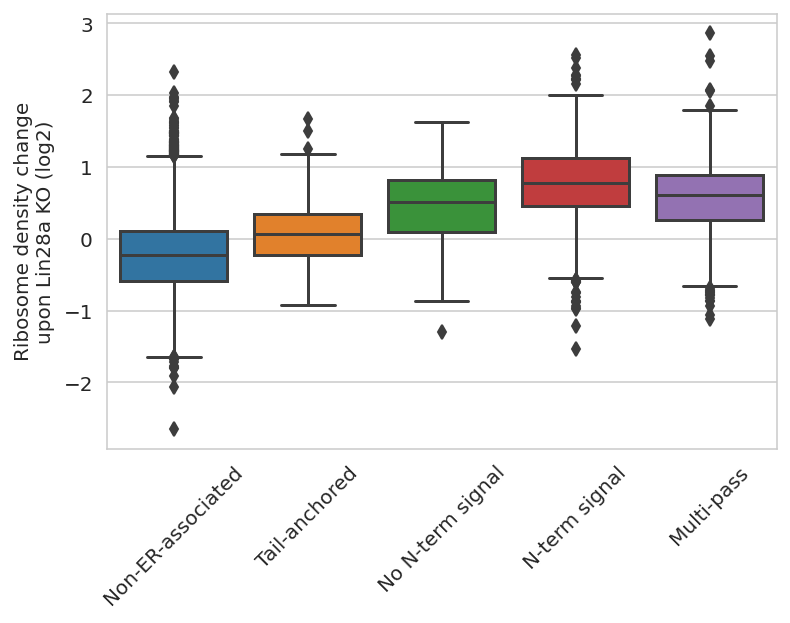

In [22]:
# sns.set_style("whitegrid")

g = sns.boxplot(data=merge_df, x='region', y='log2ratio', order=['Non-ER-associated','Tail-anchored','No N-term signal','N-term signal','Multi-pass'])
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_xlabel('')
g.set_ylabel('Ribosome density change\nupon Lin28a KO (log2)')

# Test if ribosome stall at N-term signal

In [33]:
def trans_type(df):
    df['trans_type'] = np.where(df['gene_id'].isin(tail_genes), 'Tail-anchored',
                                            np.where(df['gene_id'].isin(multi_genes), 'Multi-pass',
                                                    np.where(df['gene_id'].isin(signal_genes), 'N-term signal',
                                                            np.where(df['gene_id'].isin(single_genes), 'No N-term signal', 'Non-ER-associated'))))
    return df

In [34]:
siLuc_df = select_highly_expressing_genes('siLuc_transcriptome.bed')
siLin28a_df= select_highly_expressing_genes('siLin28a_transcriptome.bed')


In [35]:
siLin28a_df_genes = siLin28a_df.groupby(['gene_id']).sum()['rpm'].to_dict()
siLuc_df_genes = siLuc_df.groupby(['gene_id']).sum()['rpm'].to_dict()

In [36]:
siLin28a_df['rpm_ratio'] = siLin28a_df.apply(lambda x: x['rpm'] / siLin28a_df_genes[x['gene_id']] * 100, axis=1)
siLuc_df['rpm_ratio'] = siLuc_df.apply(lambda x: x['rpm'] / siLuc_df_genes[x['gene_id']] * 100, axis=1)

siLin28a_df['cds_len'] = siLin28a_df['transcript_id'].map(cdslen_dic)
siLuc_df['cds_len'] = siLuc_df['transcript_id'].map(cdslen_dic)
siLin28a_df

,gene_name,gene_id,transcript_id,reltostart-asite,rpm,rpm_ratio,cds_len
0,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-163,0.069661,0.113122,2856
1,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-145,0.069661,0.113122,2856
2,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-142,0.139321,0.226244,2856
3,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-139,0.069661,0.113122,2856
4,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-132,0.139321,0.226244,2856
...,...,...,...,...,...,...,...
1306164,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,1525,0.069661,0.371747,1758
1306165,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,2029,0.069661,0.371747,1758
1306166,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,3183,0.069661,0.371747,1758
1306167,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,3752,0.069661,0.371747,1758


# Compare the coverage between start and stop region 

In [37]:

def select_regions(target_df, group, dist):
    # target_start = target_df.loc[target_df['reltostart-asite'].isin(dist)]
    # target_stop = target_df.loc[target_df['reltostop-asite'].isin(stoprange)]
    # target_stop = target_stop.groupby(['trans_type','gene_id']).mean()['rpm_ratio'].to_frame('stop_ratio')
    # target_stop = target_stop.groupby(['trans_type','gene_id']).sum()['rpm_ratio'].groupby(['trans_type']).mean().to_frame('stop_ratio')
    # return
    target_start = target_df.loc[target_df['reltostart-asite'].isin(dist)]
    target_start = target_start.groupby(['trans_type','gene_id']).mean()['rpm_ratio'].to_frame('start_ratio')

    # target_start = target_start.groupby(['trans_type','gene_id']).sum()['rpm_ratio'].groupby(['trans_type']).mean().to_frame('start_ratio')
    # target_region = pd.merge(target_start, target_stop, on=['trans_type','gene_id'], how='outer')
    target_start['group'] = group
    return target_start

In [38]:


# siLuc_region = select_regions(siLuc_df, 'siLuc')
# siLin28a_region = select_regions(siLin28a_df, 'siLin28a')
# df_region = siLuc_region.append(siLin28a_region).reset_index()
# df_region 

In [42]:
siLuc_df

,gene_name,gene_id,transcript_id,reltostart-asite,rpm,rpm_ratio,cds_len
0,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-166,0.052777,0.041000,2856
1,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-164,0.052777,0.041000,2856
2,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-141,0.052777,0.041000,2856
3,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-132,0.844434,0.656007,2856
4,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-131,0.263886,0.205002,2856
...,...,...,...,...,...,...,...
1589822,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,1693,0.052777,0.175439,1758
1589823,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,1695,0.052777,0.175439,1758
1589824,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,1737,0.052777,0.175439,1758
1589825,Ythdf3,ENSMUSG00000047213,ENSMUST00000108345.9,2466,0.052777,0.175439,1758


In [51]:
startrange = range(6,37)
stoprange = range(-37,-6)
siLuc_region = select_regions(trans_type(siLuc_df), 'siLuc', startrange).drop('group',axis=1)
siLin28a_region = select_regions(trans_type(siLin28a_df), 'siLin28a', startrange).drop('group',axis=1)


df_region = siLin28a_region.div(siLuc_region).reset_index().dropna()
df_region

,trans_type,gene_id,start_ratio
0,Multi-pass,ENSMUSG00000000194,0.738773
1,Multi-pass,ENSMUSG00000000738,0.875536
2,Multi-pass,ENSMUSG00000000959,0.765325
3,Multi-pass,ENSMUSG00000001138,1.321078
4,Multi-pass,ENSMUSG00000001436,0.968037
...,...,...,...
6743,Tail-anchored,ENSMUSG00000067825,1.071429
6744,Tail-anchored,ENSMUSG00000067847,0.644775
6745,Tail-anchored,ENSMUSG00000071180,1.407833
6746,Tail-anchored,ENSMUSG00000073155,1.305094


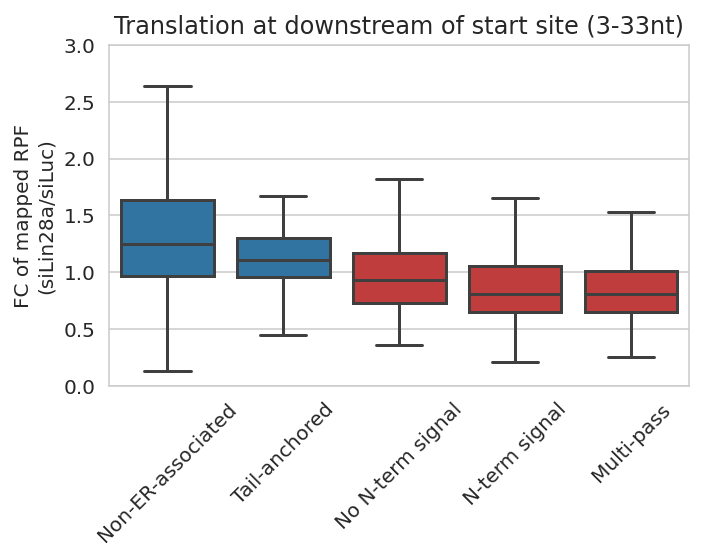

In [52]:
fig, ax = plt.subplots(figsize=(5,4), sharey=True)
color_dic = {'Non-ER-associated':'#1f77b4', 'Tail-anchored':'#1f77b4', 'No N-term signal':'#d62728', 'N-term signal':'#d62728', 'Multi-pass':'#d62728'}
g = sns.boxplot(data=df_region, x='trans_type', y='start_ratio', showfliers=False, palette=color_dic, order=['Non-ER-associated','Tail-anchored','No N-term signal','N-term signal','Multi-pass'])
g.set_ylim(0, 3)

g.set_xticklabels(g.get_xticklabels(), rotation=45, fontsize=10)
g.set_xlabel('')
g.set_ylabel('FC of mapped RPF\n(siLin28a/siLuc)')
g.set_title('Translation at downstream of start site (3-33nt)')
# plt.axhline(y=1, color='black', linestyle='--')
fig.tight_layout()

# translation at start codon (translation initiation)

In [53]:
startrange = range(0,3)
stoprange = range(-37,-6)
siLuc_region = select_regions(trans_type(siLuc_df), 'siLuc', startrange).drop('group',axis=1)
siLin28a_region = select_regions(trans_type(siLin28a_df), 'siLin28a', startrange).drop('group',axis=1)


df_region = siLin28a_region.div(siLuc_region).reset_index().dropna()
df_region

,trans_type,gene_id,start_ratio
0,Multi-pass,ENSMUSG00000000194,1.269347
1,Multi-pass,ENSMUSG00000000738,2.042918
2,Multi-pass,ENSMUSG00000000959,1.490198
3,Multi-pass,ENSMUSG00000001138,1.029412
4,Multi-pass,ENSMUSG00000001576,0.803657
...,...,...,...
3604,Tail-anchored,ENSMUSG00000071180,2.524390
3605,Tail-anchored,ENSMUSG00000073155,1.633784
3606,Tail-anchored,ENSMUSG00000074218,0.653153
3607,Tail-anchored,ENSMUSG00000092349,1.185950


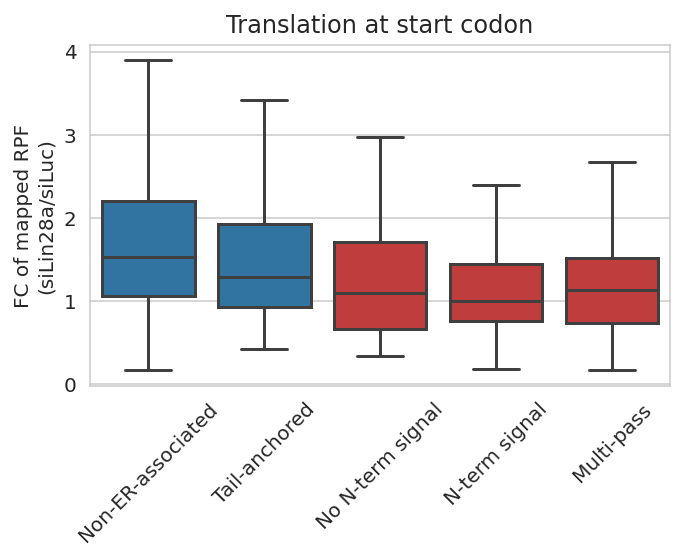

In [55]:
fig, ax = plt.subplots(figsize=(5,4), sharey=True)
color_dic = {'Non-ER-associated':'#1f77b4', 'Tail-anchored':'#1f77b4', 'No N-term signal':'#d62728', 'N-term signal':'#d62728', 'Multi-pass':'#d62728'}
g = sns.boxplot(data=df_region, x='trans_type', y='start_ratio', showfliers=False, palette=color_dic, order=['Non-ER-associated','Tail-anchored','No N-term signal','N-term signal','Multi-pass'])
# g.set_ylim(0, 3)

g.set_xticklabels(g.get_xticklabels(), rotation=45, fontsize=10)
g.set_xlabel('')
g.set_ylabel('FC of mapped RPF\n(siLin28a/siLuc)')
g.set_title('Translation at start codon')
# plt.axhline(y=1, color='black', linestyle='--')
fig.tight_layout()

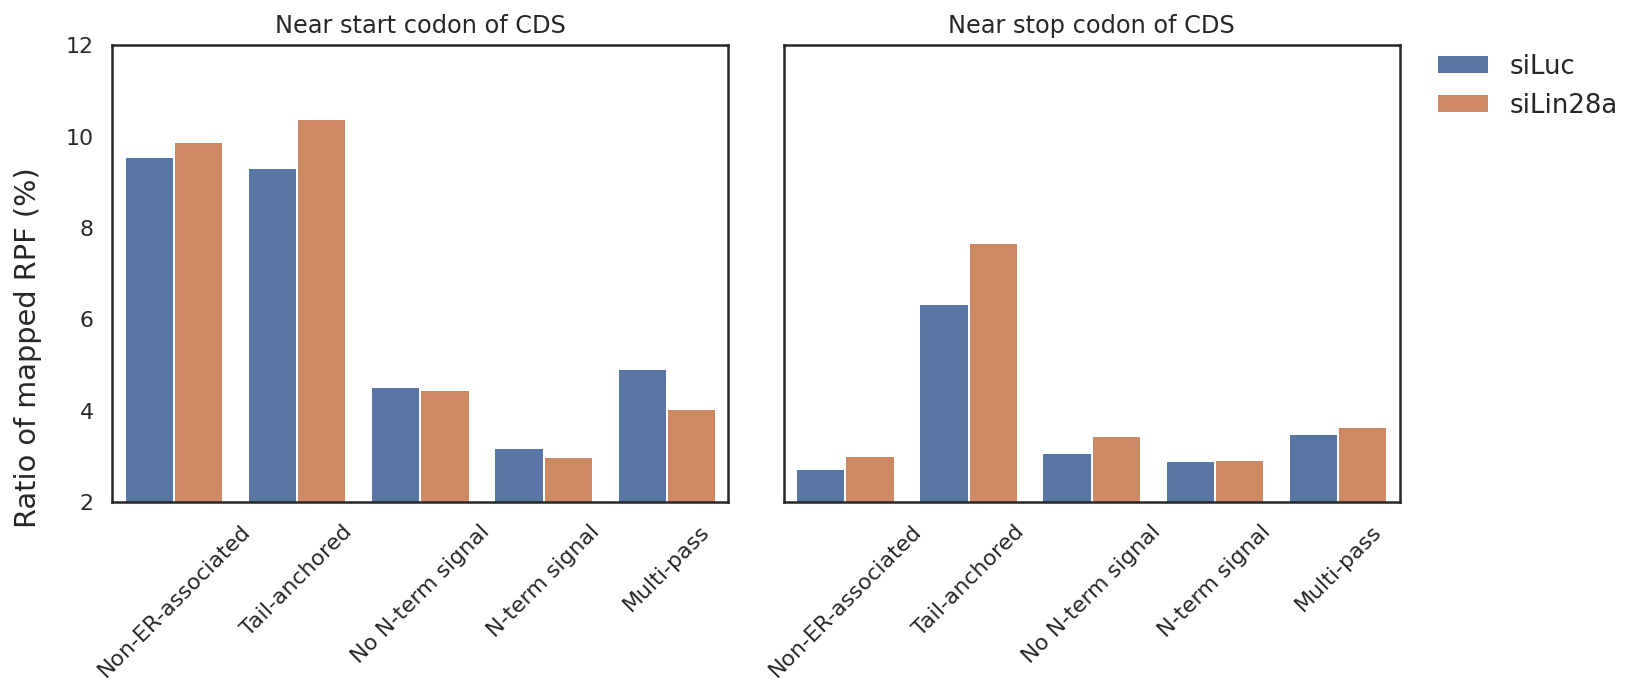

In [390]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
title_list=['start','stop']
for num, region in enumerate(['start_ratio','stop_ratio']):
    g = sns.barplot(x='trans_type', y=region, data=df_region, hue='group', ax=ax[num], order=['Non-ER-associated','Tail-anchored','No N-term signal','N-term signal','Multi-pass'])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_xlabel('')
    g.set_ylabel('')
    g.set_title('Near '+title_list[num]+' codon of CDS')
    g.set_ylim(2,12)
    g.legend([],[],frameon=False)
handles, labels = plt.gca().get_legend_handles_labels()
leg = fig.legend(handles[:], labels[:], bbox_to_anchor=(1.15,0.94), fontsize=13, ncol=1,frameon=False)
leg._legend_box.align = "left"
leg.get_frame().set_edgecolor("black")
fig.supylabel('Ratio of mapped RPF (%)')
fig.tight_layout()


In [395]:
# startrange = range(12,33)
# stoprange = range(-33,-12)
# siLin28a_start = siLin28a_df.loc[siLin28a_df['reltostart-asite'].isin(startrange)]
# siLin28a_stop = siLin28a_df.loc[siLin28a_df['reltostop-asite'].isin(stoprange)]


# siLuc_start = siLuc_df.loc[siLuc_df['reltostart-asite'].isin(startrange)]
# siLuc_stop = siLuc_df.loc[siLuc_df['reltostop-asite'].isin(stoprange)]
# siLuc_stop = siLuc_stop.groupby(['trans_type','gene_id']).sum()['rpm_ratio'].groupby(['trans_type']).mean().to_frame('stop_ratio')

# siLuc_start = siLuc_df.loc[siLuc_df['reltostart-asite'].isin(startrange)]
# siLuc_start = siLuc_start.groupby(['trans_type','gene_id']).sum()['rpm_ratio'].groupby(['trans_type']).mean().to_frame('start_ratio')
# siLuc_region = pd.merge(siLuc_start, siLuc_stop, on='trans_type', how='outer')
# siLuc_region['group'] = 'siLuc'


# # siLuc_stop = siLuc_stop.reindex(pd.MultiIndex.from_product([siLuc_stop.index.get_level_values('gene_id'),stoprange], names=['gene_id','reltostop-asite'])).fillna(0).reset_index()


In [396]:
# siLuc_df['signaldist'] = siLuc_df.apply(lambda x: x['reltostart-asite'] - nsignal_prot_dic[x['gene_id']][1] if x['gene_id'] in nsignal_prot_dic.keys() else None, axis=1)
# siLin28a_df['signaldist'] = siLin28a_df.apply(lambda x: x['reltostart-asite'] - nsignal_prot_dic[x['gene_id']][1] if x['gene_id'] in nsignal_prot_dic.keys() else None, axis=1)

# siLuc_df['signaldist_group'] = np.where(siLuc_df['signaldist'] <=0, True, False)
# siLin28a_df['signaldist_group'] = np.where(siLin28a_df['signaldist'] <=0, True, False)

# siLuc_df = siLuc_df.loc[siLuc_df['signaldist'].notnull()]
# siLin28a_df = siLin28a_df.loc[siLin28a_df['signaldist'].notnull()]


# siLin28a_df

In [397]:
# siLuc_ratio = siLuc_df.groupby(['gene_id','signaldist_group']).sum()[['rpm_ratio']].reset_index()
# siLin28a_ratio = siLin28a_df.groupby(['gene_id','signaldist_group']).sum()[['rpm_ratio']].reset_index()
# siLuc_ratio.set_index(['gene_id','signaldist_group'], inplace=True)
# siLin28a_ratio.set_index(['gene_id','signaldist_group'], inplace=True)
# siLuc_ratio = siLuc_ratio.reindex(pd.MultiIndex.from_product([siLuc_ratio.index.get_level_values('gene_id'), [True, False]], names=['gene_id','signaldist_group'])).fillna(0).reset_index()
# siLin28a_ratio = siLin28a_ratio.reindex(pd.MultiIndex.from_product([siLin28a_ratio.index.get_level_values('gene_id'), [True, False]], names=['gene_id','signaldist_group'])).fillna(0).reset_index()
# merge_ratio = pd.merge(siLuc_ratio, siLin28a_ratio, on=['gene_id','signaldist_group'], how='inner', suffixes=('_siLuc', '_siLin28a'))
# merge_ratio = merge_ratio.groupby('signaldist_group').mean()
# merge_ratio

In [398]:
# target_range = range(-50,51)
# siLin28a_signal = siLin28a_df.loc[siLin28a_df['signaldist'].isin(target_range)]
# siLuc_signal = siLuc_df.loc[siLuc_df['signaldist'].isin(target_range)]


# siLin28a_signal = siLin28a_signal[['transcript_id','signaldist','rpm_ratio']].set_index(['transcript_id','signaldist'])
# siLuc_signal = siLuc_signal[['transcript_id','signaldist','rpm_ratio']].set_index(['transcript_id','signaldist'])

# siLuc_signal = siLuc_signal.reindex(pd.MultiIndex.from_product([siLuc_signal.index.get_level_values('transcript_id'),target_range], names=['transcript_id','signaldist'])).fillna(0)
# siLin28a_signal = siLin28a_signal.reindex(pd.MultiIndex.from_product([siLin28a_signal.index.get_level_values('transcript_id'),target_range], names=['transcript_id','signaldist'])).fillna(0)
# siLuc_signal

In [399]:
# siLuc_signal = siLuc_signal.groupby('signaldist').mean()[['rpm_ratio']]
# siLin28a_signal = siLin28a_signal.groupby('signaldist').mean()[['rpm_ratio']]

# signal_merge = pd.merge(siLuc_signal, siLin28a_signal, on='signaldist', how='outer', suffixes=['_Luc','_Lin28a']).fillna(0).stack().reset_index()
# signal_merge.columns = ['signaldist','group','ratio']
# signal_merge['group'].replace(['rpm_ratio_Luc','rpm_ratio_Lin28a'], ['Luc','Lin28a'], inplace=True)
# g = sns.lineplot(data=signal_merge, x='signaldist', y='ratio', hue='group')
# g.set_xlabel("Distance from 3'end of signal peptide", fontsize=15)

# Test if rpf ratio decrease at stop codon site

In [400]:
siLin28a_df['reltostop-asite'] = siLin28a_df.apply(lambda x: x['reltostart-asite'] - cdslen_dic[x['transcript_id']], axis=1)
siLuc_df['reltostop-asite'] = siLuc_df.apply(lambda x: x['reltostart-asite'] - cdslen_dic[x['transcript_id']], axis=1)

siLin28a_df.head()

,gene_name,gene_id,transcript_id,reltostart-asite,rpm,rpm_ratio,trans_type,cds_len,reltostop-asite
0,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-163,0.069661,0.113122,Non-ER-associated,2856,-3019
1,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-145,0.069661,0.113122,Non-ER-associated,2856,-3001
2,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-142,0.139321,0.226244,Non-ER-associated,2856,-2998
3,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-139,0.069661,0.113122,Non-ER-associated,2856,-2995
4,Ap2b1,ENSMUSG00000035152,ENSMUST00000018875.13,-132,0.139321,0.226244,Non-ER-associated,2856,-2988


In [419]:
sns.set_theme(style='white')

startsite =range(-50,31)
stopsite =range(-30,51)

def start_stop_region(target_df, col, target_range):
    df = target_df.loc[target_df[col].isin(target_range)]

    df = df[['gene_id',col,'rpm_ratio']].set_index(['gene_id',col])

    df = df.reindex(pd.MultiIndex.from_product([df.index.get_level_values('gene_id'),target_range], names=['gene_id',col])).fillna(0).reset_index()
    df = trans_type(df)
    df = df.groupby(['trans_type',col]).mean()[['rpm_ratio']]
    return  df



In [421]:
siLin28a_start = start_stop_region(siLin28a_df, 'reltostart-asite',startsite)
siLuc_start = start_stop_region(siLuc_df, 'reltostart-asite',startsite)
siLin28a_stop = start_stop_region(siLin28a_df, 'reltostop-asite',stopsite)
siLuc_stop = start_stop_region(siLuc_df, 'reltostop-asite',stopsite)

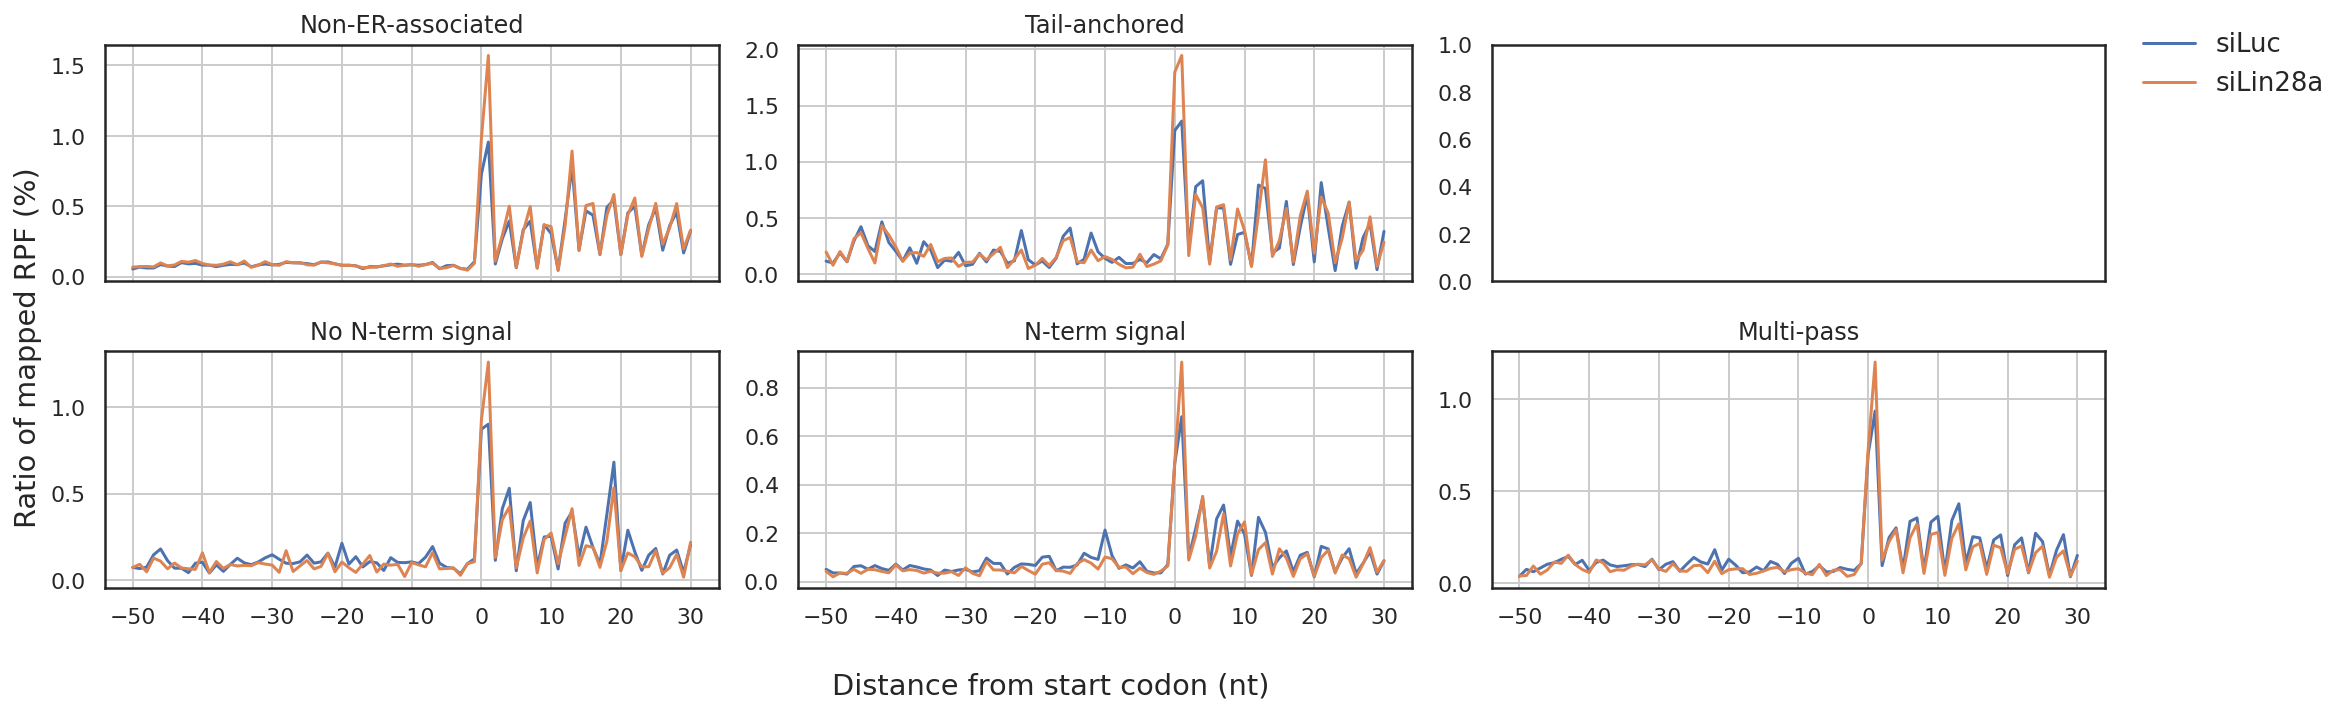

In [423]:
start_merge = pd.merge(siLuc_start, siLin28a_start, on=['trans_type','reltostart-asite'], how='outer', suffixes=['_Luc','_Lin28a']).fillna(0).stack().reset_index()
start_merge.columns = ['trans_type','reltostart-asite','group','ratio']
start_merge['group'].replace(['rpm_ratio_Luc','rpm_ratio_Lin28a'], ['siLuc','siLin28a'], inplace=True)
trans_list =['Non-ER-associated', 'Tail-anchored', '','No N-term signal', 'N-term signal', 'Multi-pass']
fig, ax = plt.subplots(2, 3, figsize=(15,5), sharex=True, sharey=False)
for num, i in enumerate(trans_list):
    if i=='':
        continue
    cnum = num%3
    rnum = int(num/3)
    df = start_merge.loc[start_merge['trans_type']==i]
    g = sns.lineplot(data=df, x='reltostart-asite', y='ratio', hue='group', ax=ax[rnum, cnum])
    g.set_title(i)
    g.legend([],[], frameon=False)
    g.set_ylabel('')
    g.set_xlabel('')
    g.grid()
fig.supylabel('Ratio of mapped RPF (%)')
fig.supxlabel('Distance from start codon (nt)')
handles, labels = plt.gca().get_legend_handles_labels()
leg = fig.legend(handles[:], labels[:], bbox_to_anchor=(1.1,0.97), fontsize=13, ncol=1,frameon=False)
leg._legend_box.align = "left"
leg.get_frame().set_edgecolor("black")
fig.tight_layout()

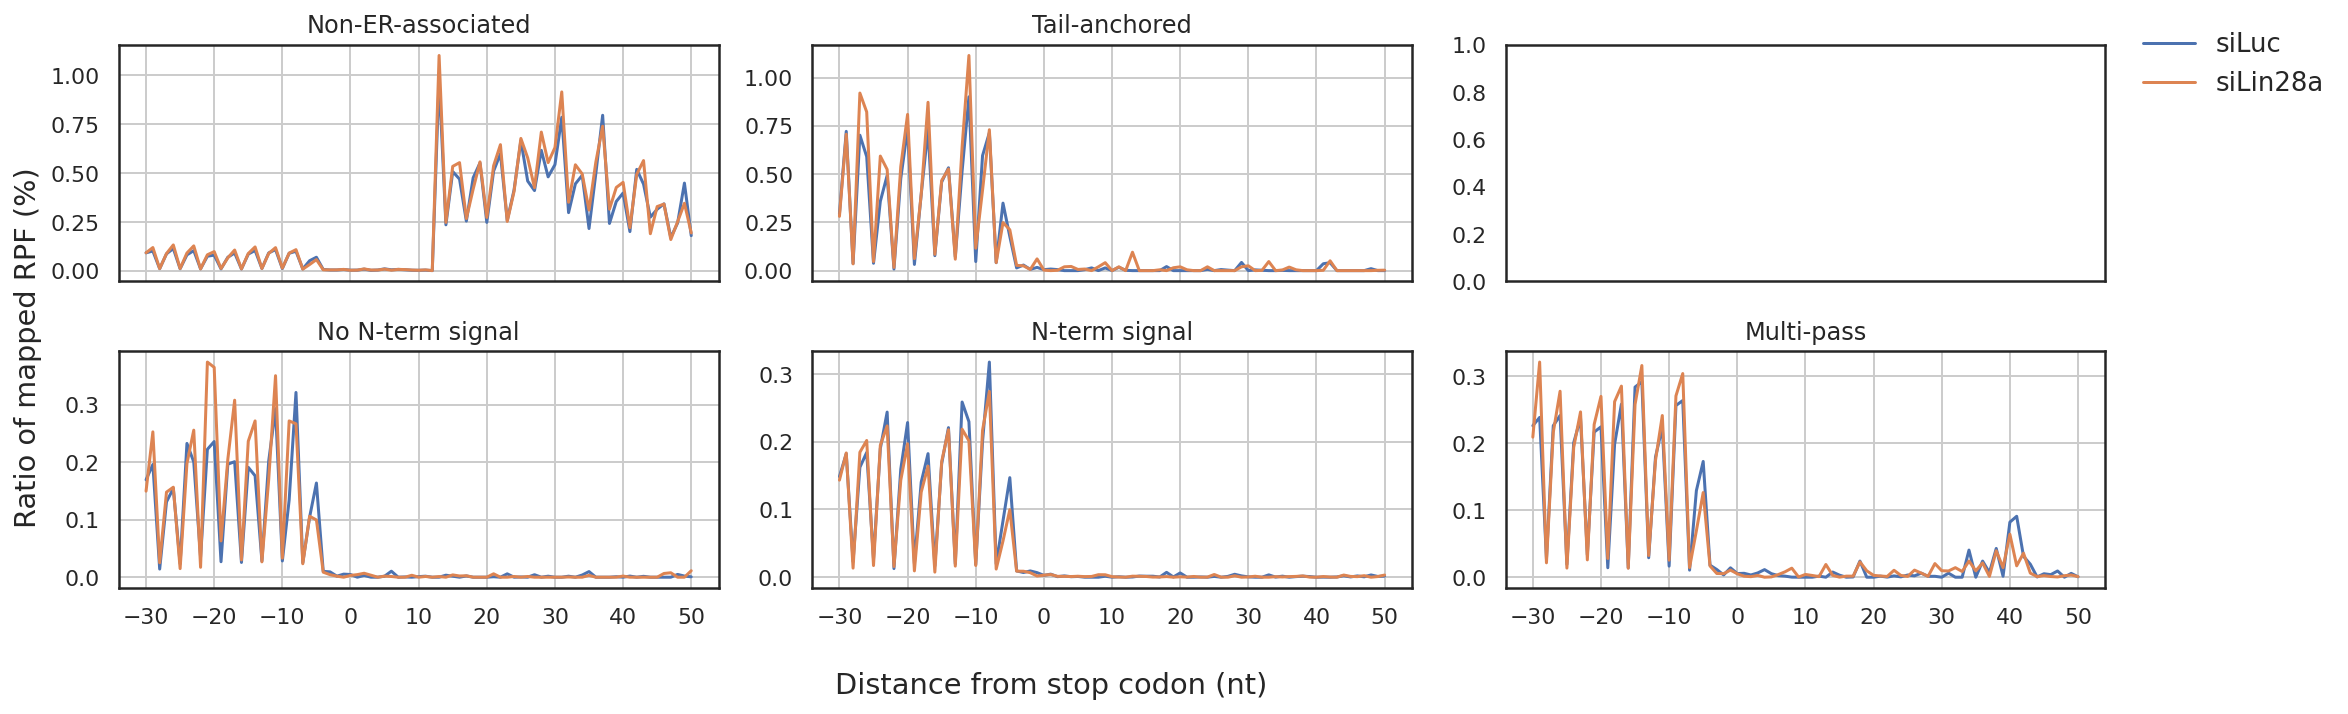

In [425]:
stop_merge = pd.merge(siLuc_stop, siLin28a_stop, on=['trans_type','reltostop-asite'], how='outer', suffixes=['_Luc','_Lin28a']).fillna(0).stack().reset_index()
stop_merge.columns = ['trans_type','reltostop-asite','group','ratio']
stop_merge['group'].replace(['rpm_ratio_Luc','rpm_ratio_Lin28a'], ['siLuc','siLin28a'], inplace=True)
trans_list =['Non-ER-associated', 'Tail-anchored', '','No N-term signal', 'N-term signal', 'Multi-pass']
fig, ax = plt.subplots(2, 3, figsize=(15,5), sharex=True, sharey=False)
for num, i in enumerate(trans_list):
    if i=='':
        continue
    cnum = num%3
    rnum = int(num/3)
    df = stop_merge.loc[stop_merge['trans_type']==i]
    g = sns.lineplot(data=df, x='reltostop-asite', y='ratio', hue='group', ax=ax[rnum, cnum])
    g.set_title(i)
    g.legend([],[], frameon=False)
    g.set_ylabel('')
    g.set_xlabel('')
    g.grid()
fig.supylabel('Ratio of mapped RPF (%)')
fig.supxlabel('Distance from stop codon (nt)')
handles, labels = plt.gca().get_legend_handles_labels()
leg = fig.legend(handles[:], labels[:], bbox_to_anchor=(1.1,0.97), fontsize=13, ncol=1,frameon=False)
leg._legend_box.align = "left"
leg.get_frame().set_edgecolor("black")
fig.tight_layout()

### start codon에서 Lin28a가 더 낮아보인다. (translation initiation문제인지 확인필요)

Lin28a binding motif가 CDS에 있어서 translation inhibition을 발생시켰다면, stop codon때 붙는 ratio가 감소해야하는데, 그렇지 않음.
따라서 CDS지역에서 rpf stalling과 같은 현상에 의한것이 아닐 가능성이 있음.

# TMD와 주변에서 RPF binding이 바뀌는지 확인

In [257]:
siLuc_df = select_highly_expressing_genes('siLuc_transcriptome.bed')
siLuc_trans = get_transmem_dist(siLuc_df, Dist)
siLuc_count = trans_typing(siLuc_trans, ratio=False)
siLuc_ratio = trans_typing(siLuc_trans, ratio=True)
siLuc_ratio.head()

/tmp/ipykernel_1085848/4057274380.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio.loc[df_ratio.sum(level=['gene_id','trans_type'])>20]
/tmp/ipykernel_1085848/4057274380.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio / df_ratio.sum(level='gene_id')


,gene_id,trans_type,region,ratio
0,ENSMUSG00000006445,N-term signal,Downstream,0.266898
1,ENSMUSG00000006445,N-term signal,TMD,0.410745
2,ENSMUSG00000006445,N-term signal,Upstream,0.322357
3,ENSMUSG00000007458,N-term signal,Downstream,0.450622
4,ENSMUSG00000007458,N-term signal,TMD,0.276349


In [258]:
siLin28a_df = select_highly_expressing_genes('siLin28a_transcriptome.bed')
siLin28a_trans = get_transmem_dist(siLin28a_df, Dist)
siLin28a_count = trans_typing(siLin28a_trans, ratio = False)
siLin28a_ratio = trans_typing(siLin28a_trans, ratio = True)

siLin28a_ratio 

/tmp/ipykernel_1085848/4057274380.py:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio.loc[df_ratio.sum(level=['gene_id','trans_type'])>20]
/tmp/ipykernel_1085848/4057274380.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_ratio = df_ratio / df_ratio.sum(level='gene_id')


,gene_id,trans_type,region,ratio
0,ENSMUSG00000005672,N-term signal,Downstream,0.269307
1,ENSMUSG00000005672,N-term signal,TMD,0.461386
2,ENSMUSG00000005672,N-term signal,Upstream,0.269307
3,ENSMUSG00000006445,N-term signal,Downstream,0.235294
4,ENSMUSG00000006445,N-term signal,TMD,0.408253
...,...,...,...,...
213,ENSMUSG00000070394,Multi-pass,TMD,0.599707
214,ENSMUSG00000070394,Multi-pass,Upstream,0.073314
215,ENSMUSG00000078681,Multi-pass,Downstream,0.076789
216,ENSMUSG00000078681,Multi-pass,TMD,0.361257


In [273]:
df1 = siLuc_ratio.set_index(['gene_id','trans_type','region'])
df2 = siLin28a_ratio.set_index(['gene_id','trans_type','region'])

df_ratio = df1.div(df2)
df_ratio = df_ratio.dropna()
df_ratio = df_ratio.reset_index()
# df_ratio = df_ratio.loc[df_ratio['trans_type']!='Tail-anchored']
df_ratio

,gene_id,trans_type,region,ratio
0,ENSMUSG00000006445,N-term signal,Downstream,1.134315
1,ENSMUSG00000006445,N-term signal,TMD,1.006105
2,ENSMUSG00000006445,N-term signal,Upstream,0.904346
3,ENSMUSG00000007458,N-term signal,Downstream,0.987801
4,ENSMUSG00000007458,N-term signal,TMD,1.190608
...,...,...,...,...
111,ENSMUSG00000058569,N-term signal,Downstream,1.100187
112,ENSMUSG00000058569,N-term signal,TMD,0.942813
113,ENSMUSG00000070394,Multi-pass,Downstream,1.017244
114,ENSMUSG00000070394,Multi-pass,TMD,0.994764


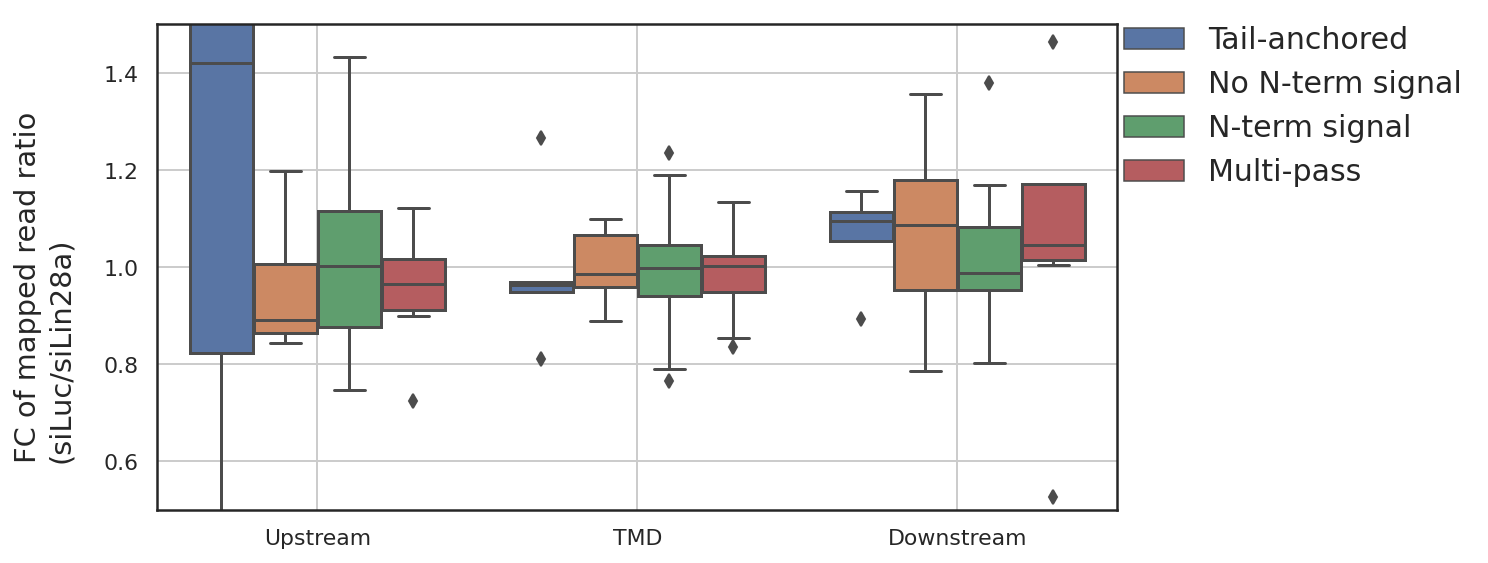

In [275]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=(8, 4), sharey=True)
title_list = ['siLuc','siLin28a']
# for num, df in enumerate([siLuc_ratio, siLin28a_ratio]):
g = sns.boxplot(data=df_ratio, x='region', y='ratio',hue='trans_type', order=['Upstream','TMD','Downstream'], hue_order = ['Tail-anchored','No N-term signal','N-term signal','Multi-pass'])
# g.set_title('FC of RPF', fontsize=15)
g.legend([],[], frameon=False)
handles, labels = plt.gca().get_legend_handles_labels()
g.grid()
g.set_xlabel('')
g.set_ylabel('')
g.set_ylim(0.5, 1.5)
fig.legend(handles[:], labels[:], bbox_to_anchor=(1.30,1), fontsize=15, ncol=1,frameon=False)
fig.supylabel('FC of mapped read ratio\n(siLuc/siLin28a)')
fig.tight_layout()

# Check for Lin28A accumulation in particular region of membrane genes

In [ ]:
def select_highly_expressing_RMA(file):
    rpf_all = pd.read_csv(file, sep='\t', names=['transcript_id','start','end','count'])
    # select representative isoforms
    rpf_all = pd.merge(rpf_all, codinglengths_gene, on='transcript_id', how='inner')
    rpf_all['reltostart-asite'] = rpf_all['start'] - rpf_all['utr5'] + 18
    rpf_all = rpf_all.loc[rpf_all['reltostart-asite']>0]
    # select highly expressing genes
    rpf = rpf_all.groupby(['gene_name','transcript_id']).sum().sort_values(by='count', ascending=False)[['count']].reset_index()
    total_read = rpf['count'].sum()
    rpf['rpm'] = rpf['count']/total_read * 10e5
    high_rpf = rpf.loc[rpf['rpm']>=1].copy()
    high_rpf = rpf_all.loc[rpf_all['transcript_id'].isin(high_rpf['transcript_id'])].copy()
    high_rpf['gene_id'] = high_rpf['gene_id'].str.split('.',expand=True)[0]
    high_rpf['rpm'] = high_rpf['count']/total_read * 10e5
    high_rpf = high_rpf[['gene_name','gene_id','transcript_id','reltostart-asite','rpm']]
    return high_rpf


In [153]:
siLuc_RNA= select_highly_expressing_genes('siLuc_RNA_transcriptome.bed')
siLuc_RNA = siLuc_RNA.groupby(['gene_id']).sum()[['rpm']]

siLin28a_RNA= select_highly_expressing_genes('siLin28a_RNA_transcriptome.bed')
siLin28a_RNA = siLin28a_RNA.groupby(['gene_id']).sum()[['rpm']]
siLin28a_RNA.head()


,rpm
gene_id,
ENSMUSG00000089699,5649.717514
ENSMUSG00000103147,22598.870056
ENSMUSG00000103161,966101.694915
ENSMUSG00000103201,5649.717514


In [155]:
siLin28a_RNA

,rpm
gene_id,
ENSMUSG00000089699,5649.717514
ENSMUSG00000103147,22598.870056
ENSMUSG00000103161,966101.694915
ENSMUSG00000103201,5649.717514


In [154]:
merge_RNA = pd.merge(siLuc_RNA, siLin28a_RNA, on='gene_id', how='inner', suffixes=('_siLuc', '_siLin28a'))
merge_RNA['ratio'] = merge_RNA['rpm_siLin28a'] / merge_RNA['rpm_siLuc']
merge_RNA['log2ratio'] = np.log2(merge_RNA['ratio'])
merge_RNA.reset_index(inplace=True)
merge_RNA['region'] = transmem_region(merge_RNA, 'gene_id')
merge_RNA

,gene_id,rpm_siLuc,rpm_siLin28a,ratio,log2ratio,region
0,ENSMUSG00000103147,224.351784,22598.870056,100.729621,6.654344,Non-ER-associated
1,ENSMUSG00000103161,15640.524342,966101.694915,61.769137,5.948814,Non-ER-associated
